In [1]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
import model
import train
import lossfn
import plots
from custom_dataset import CustomDataset
from preprocess import ClipTransform, ReplaceNaN
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from util import save_model, load_model, save_result, load_result
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi

Tue Jun 20 10:40:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:1A:00.0 Off |                    0 |
| N/A   53C    P0    71W / 250W |  15231MiB / 16160MiB |     40%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   

## Dataset

In [2]:
data_path = './data/MDISC/small_dataset/train_v2d_alpha_cubic_512x512.pkl'
labels_path = './data/MDISC/small_dataset/train_labels.pkl'

width = 512

# transforms.ToTensor assumes input dimensions (H x W x C)
transform=transforms.Compose([transforms.ToTensor(),
                              torch.log,
                              ClipTransform(min_value=-21), #-inf resulted from log 0
                              ReplaceNaN(constant=-21), # NaN resulted from log -ve values
                              transforms.Normalize(mean=[-3.6951], std=[1.3562]), # mean and std determined in `preprocess.ipynb`
                             ])
dataset = CustomDataset(data_path=data_path, labels_path=labels_path, transform=transform)

In [3]:
dataset[0][0].dtype, dataset[0][0].shape

(torch.float32, torch.Size([1, 512, 512]))

In [4]:
batch_size = 32
shuffle = True
num_workers = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

### Checking data

torch.Size([32, 1, 512, 512]) (32,) kh1.14e+07_rmp70.50
Plotting kh1.14e+07_rmp70.50


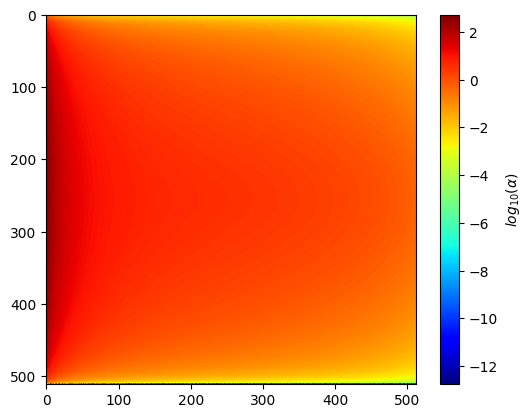

In [5]:
for x, y in dataloader:
    # Extract the data and labels from the batch
    x = x.to(device).float() # GPU
    y = np.array(y)
    print(x.shape, y.shape, y[0])
    break

print(f'Plotting {y[0]}')
fig, ax = plt.subplots()
s = plt.imshow(x[0].cpu().detach().numpy().squeeze(),
                cmap="jet")
plt.colorbar(s, label=r'$log_{10}(\alpha)$');

(tensor(0), torch.Size([512, 512]))

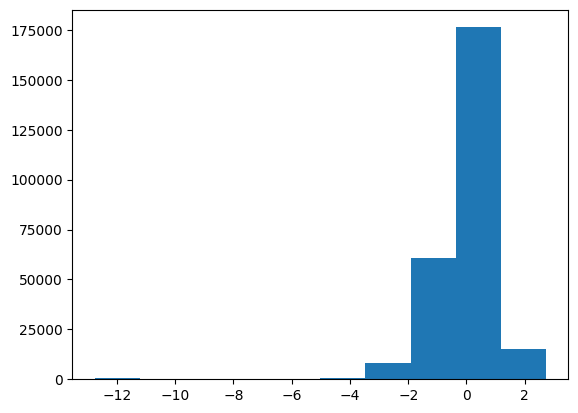

In [7]:
plt.hist(x[0][0].cpu().numpy().flatten()); np.isnan(x[0][0].cpu()).sum(), x[0][0].shape

## Model

In [6]:
from model import VAE

In [7]:
beta = 1.0
vae = VAE(image_channels=1, h_dim=256 * 1 * 1, z_dim=2, beta = beta, device=device)

## Training (+ wandb)

In [10]:
from train import train_model
import wandb

In [11]:
output_dir='my_model'
lr=1e-3
epochs=200

# 1. Organize your hyperparameters
config = SimpleNamespace(batch_size=batch_size, 
                         lr=lr,
                         epochs=epochs,
                         beta=beta)

In [12]:
wandb.login(anonymous="allow")

wandb: Currently logged in as: ikitcheng. Use `wandb login --relogin` to force relogin


True

In [11]:
vae, hist = train_model(vae, dataloader, config)

  0%|          | 0/200 [00:04<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.02 GiB (GPU 0; 15.78 GiB total capacity; 13.17 GiB already allocated; 1.45 GiB free; 13.18 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# save the model and history   
save_model(vae, model_path=f'./my_model/vae_beta{beta}_epoch{epoch}_batchsize{batch_size}_lr{lr}.pth')
save_result(hist, filename=f'./my_model/hist_vae_beta{beta}_epoch{epoch}_batchsize{batch_size}_lr{lr}.pkl')
